In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

sc.settings.set_figure_params(dpi=150)

/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
%%R
library(scran)

In [3]:
#Define a nice colour map for gene expression
colors1 = plt.cm.Reds(np.linspace(0, 1, 256))
colors2 = plt.cm.Greys_r(np.linspace(0.7,0.8,256))
colorsComb = np.vstack([colors2, colors1])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [4]:
adata = sc.read("/newdatb/home/wanglab13/scratch/wholebrain/results/agg_HE-5-4W/scanpy/write/wholebody_w3-5_V4.h5ad")
# adata = sc.read('./Data/w345_v3.h5ad')

In [5]:
adata.obs['louvain1']=adata.obs['louvain']

# 1. Sclertome lineage analysis

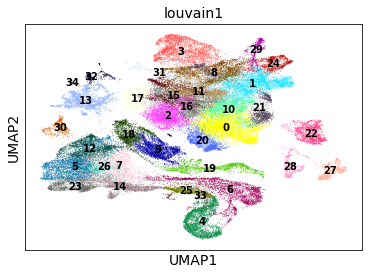

In [6]:
sc.pl.umap(adata,color='louvain1',legend_loc='on data')

In [7]:
adata_test = adata.copy()
adata_test.X = adata.raw.X

In [8]:
sclertome_clusters=['0','2','20']

In [9]:
adata_sclerotome = adata_test[adata_test.obs['louvain1'].isin(sclertome_clusters)]

In [10]:
# Perform basic filtering
sc.pp.filter_cells(adata_sclerotome, min_genes=250)

# Before doing any further processing, store a raw version of the data
adata_sclerotome.raw = adata_sclerotome

# First, save current n_counts as n_counts_pre_norm (n_counts will be replaced)
adata_sclerotome.obs['n_counts_pre_norm'] = adata_sclerotome.obs['n_counts']

# Perform total counts normalization
sc.pp.normalize_total(adata_sclerotome)

# Logarithmize the data
sc.pp.log1p(adata_sclerotome)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata_sclerotome, n_top_genes=500)

# Scale the data
sc.pp.scale(adata_sclerotome)

Trying to set attribute `.obs` of view, making a copy.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [11]:
# Perform PCA and construct neighbor graph
sc.tl.pca(adata_sclerotome, n_comps=20, svd_solver='arpack')

computing PCA with n_comps = 20
computing PCA on highly variable genes
    finished (0:00:00.64)


In [12]:
pca_mesod = adata_sclerotome.obsm['X_pca']
wg = adata_sclerotome.obs['week_stage']

In [13]:
%%R -i pca_mesod -i wg
rownames(pca_mesod) = names(wg)
pc_list = lapply(unique(wg), function(tp){
sub_pc = pca_mesod[wg == tp, , drop = FALSE]
return(sub_pc)
})
names(pc_list) = unique(wg)

In [14]:
%%R -o correct
correct = do.call(fastMNN, c(pc_list, "pc.input" = TRUE, BPPARAM = SerialParam()))$corrected

In [15]:
adata_sclerotome.obsm['X_pca'] = correct

In [16]:
sc.pp.neighbors(adata_sclerotome, n_neighbors=20, n_pcs=20, use_rep='X_pca') 
sc.tl.draw_graph(adata_sclerotome, layout='fa', iterations=400, random_state=0) # random_state=0 by default
sc.tl.diffmap(adata_sclerotome)
sc.tl.umap(adata_sclerotome)
sc.tl.louvain(adata_sclerotome)

computing neighbors


/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/umap/rp_tree.py:439: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d,

    finished (0:00:20.53) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fa"
    finished (0:01:11.36) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9872785  0.9831513  0.97772086 0.9739759  0.9674755
     0.9670136  0.9585785  0.95420736 0.9517132  0.9482962  0.94377816
     0.94079316 0.9353847  0.9341329 ]
    finished (0:00:00.50) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing UMAP
    finished (0:00:17.54) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.83) --> found 17 clusters and added
    'louvain', the cluster labels (adata.obs, cate

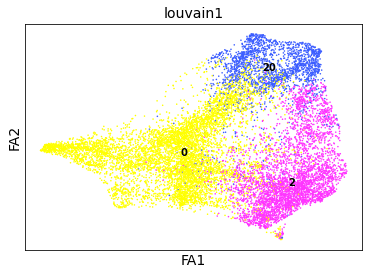

In [17]:
sc.pl.draw_graph(adata_sclerotome,color='louvain1',legend_loc='on data')

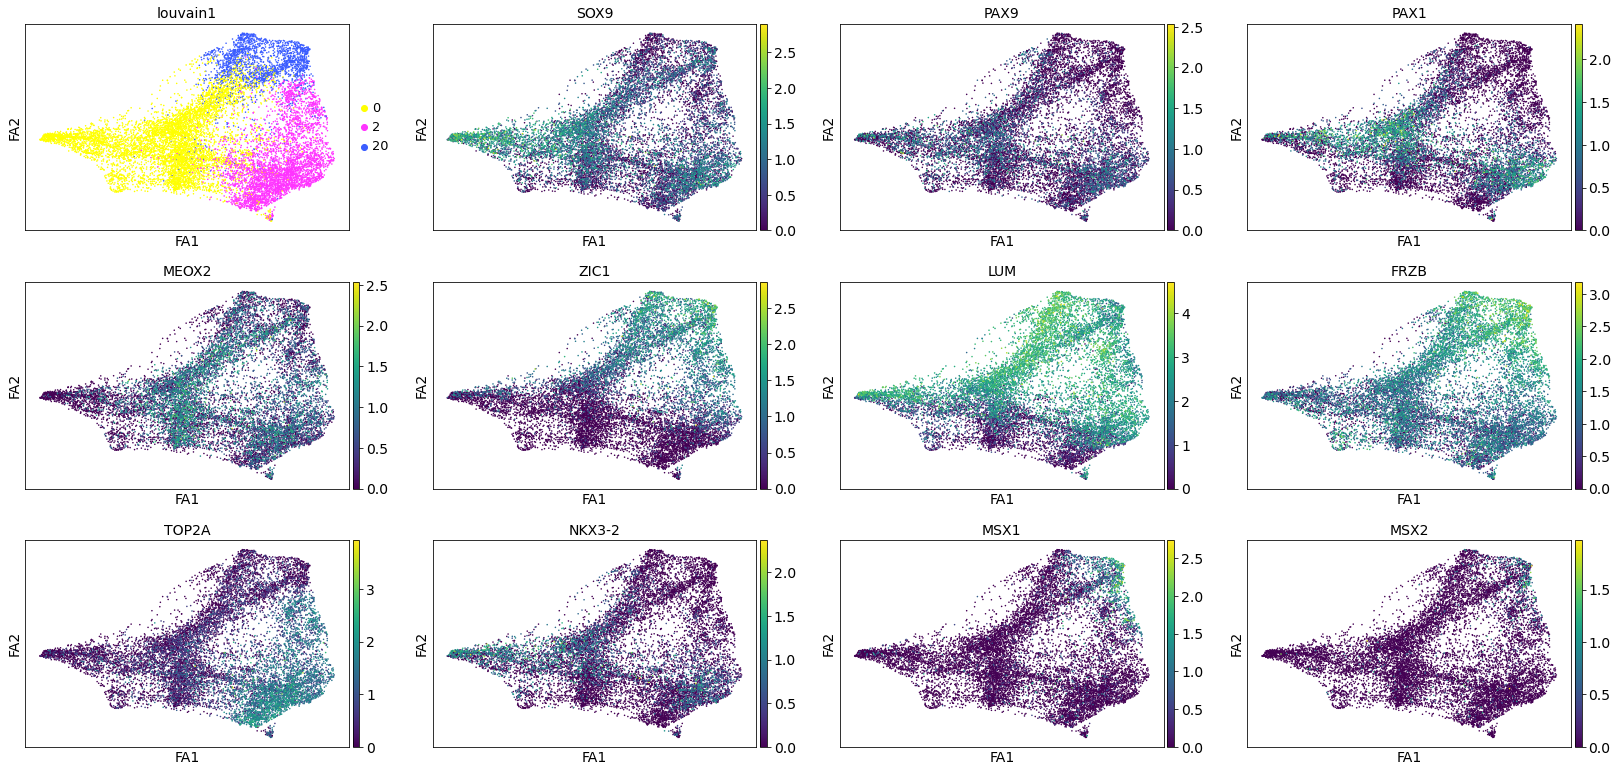

In [19]:
sc.pl.draw_graph(adata_sclerotome, color=['louvain1','SOX9','PAX9','PAX1','MEOX2','ZIC1','LUM','FRZB','TOP2A','NKX3-2','MSX1','MSX2'])

In [21]:
new_cluster_names = ['Vetebral body','Proliferating sclerotome','Vetebral arches']
adata_sclerotome.obs['louvain1_name']=adata_sclerotome.obs['louvain1']
adata_sclerotome.rename_categories('louvain1_name', new_cluster_names)

<AxesSubplot:xlabel='FA1', ylabel='FA2'>

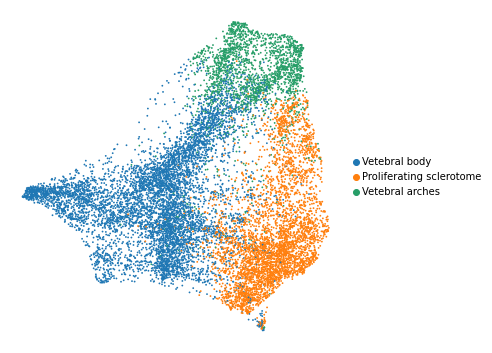

In [23]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.draw_graph(adata_sclerotome, components='1,2',color='louvain1_name',frameon=False,title='', legend_fontsize=10,ax=ax,show=False,size=13)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2f_somite_lineage_v2.pdf"), dpi=300, format='pdf', bbox_inches='tight')

<AxesSubplot:xlabel='FA1', ylabel='FA2'>

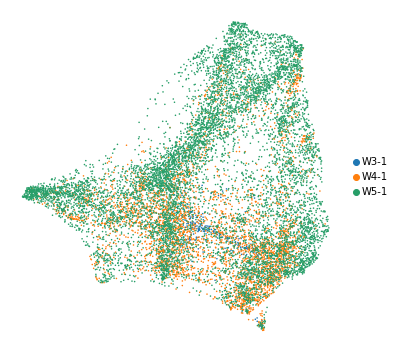

In [24]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.draw_graph(adata_sclerotome, components='1,2',color='week_stage',frameon=False,title='', legend_fontsize=10,ax=ax,show=False)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2f_somite_lineage_week_v1.pdf"), dpi=300, format='pdf', bbox_inches='tight')

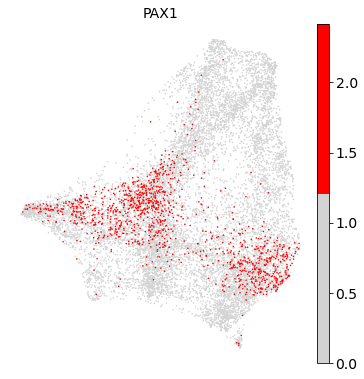

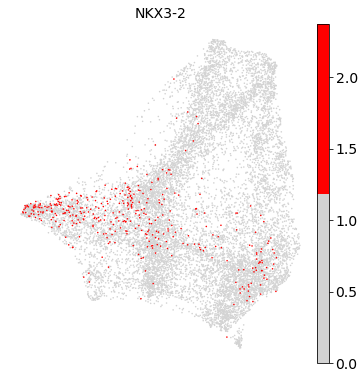

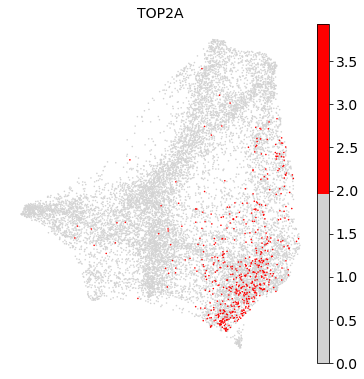

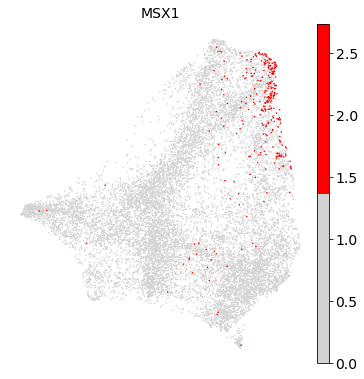

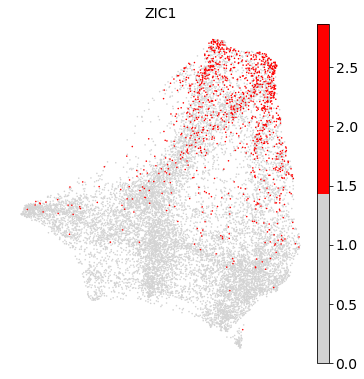

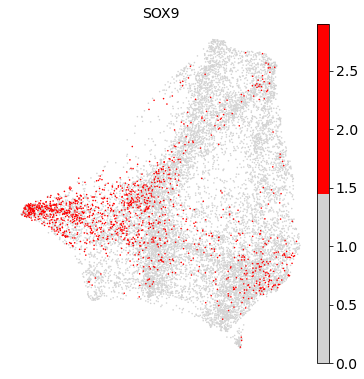

In [25]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
sclertome_genes=['PAX1','NKX3-2','TOP2A','MSX1','ZIC1','SOX9']
cmap = colors.ListedColormap(['lightgray', 'red'])
for gn in sclertome_genes:
    fig, ax = plt.subplots(figsize=(6,6))
    sc.pl.draw_graph(adata_sclerotome, components='1,2',color=gn,frameon=False,title=gn, legend_fontsize=10,ax=ax,show=False,color_map=cmap)
#     plt.savefig(os.path.join(paper_figure_dir,"Fig2e_somite_lineage_{}_v1.pdf".format(gn)), dpi=300, format='pdf', bbox_inches='tight')

In [28]:
adata_sclerotome.obs['louvain1_name'].cat.reorder_categories(['Proliferating sclerotome','Vetebral body',  'Vetebral arches'],inplace=True)

In [29]:
adata_sclerotome_v1=sc.AnnData(X=adata_sclerotome.X,
                           obs=adata_sclerotome.obs,
                           var=adata_sclerotome.var)

/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:2233: RuntimeWarning: invalid value encountered in log1p
  matrix = np.log1p(matrix)


GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[13.8, 0, 0.2])

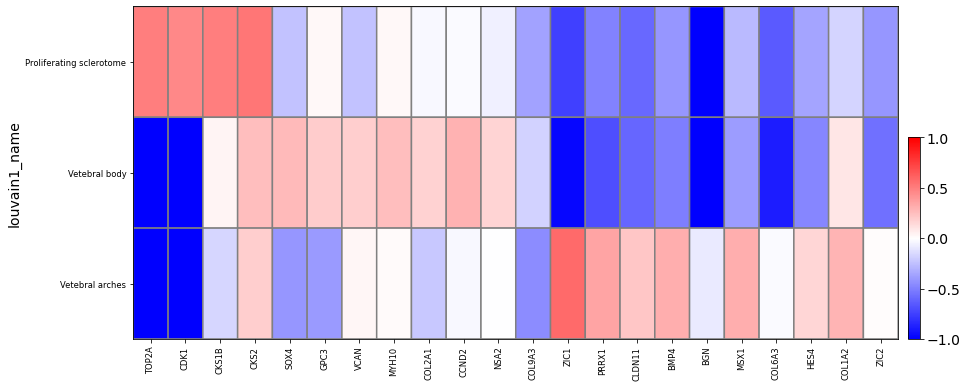

In [30]:
markers_vetebral_body=['SOX4',  'GPC3', 'VCAN',  'MYH10',  'COL2A1', 'CCND2',  'NSA2', 'COL9A3']
markers_prolif_sclerotome = ['TOP2A', 'CDK1', 'CKS1B',   'CKS2']
markers_vetebral_arches = ['ZIC1', 'PRRX1',  'CLDN11', 'BMP4', 'BGN',  'MSX1',  'COL6A3','HES4','COL1A2', 'ZIC2']
markers = markers_prolif_sclerotome+markers_vetebral_body+markers_vetebral_arches
sc.pl.matrixplot(adata_sclerotome_v1,markers,log=True,figsize=(14,6), groupby='louvain1_name',dendrogram=False,show=False,cmap='bwr',linewidth=1.5,vmax=1,vmin=-1,use_raw=False)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2h_osteoblast_rank_genes_v3.pdf"), dpi=300, format='pdf', bbox_inches='tight')

# 2 Dermamyotome lineage analysis

In [31]:
adata_test = adata.copy()
adata_test.X = adata.raw.X

In [32]:
dermamyotome_clusters=['15','11','31','10']

In [33]:
adata_dermamyotome = adata_test[adata_test.obs['louvain1'].isin(dermamyotome_clusters)]

In [34]:
# Perform basic filtering
sc.pp.filter_cells(adata_dermamyotome, min_genes=250)

# Before doing any further processing, store a raw version of the data
adata_dermamyotome.raw = adata_dermamyotome

# First, save current n_counts as n_counts_pre_norm (n_counts will be replaced)
adata_dermamyotome.obs['n_counts_pre_norm'] = adata_dermamyotome.obs['n_counts']

# Perform total counts normalization
sc.pp.normalize_total(adata_dermamyotome)

# Logarithmize the data
sc.pp.log1p(adata_dermamyotome)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata_dermamyotome, n_top_genes=500)

# Scale the data
sc.pp.scale(adata_dermamyotome)

Trying to set attribute `.obs` of view, making a copy.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [35]:
# Perform PCA and construct neighbor graph
sc.tl.pca(adata_dermamyotome, n_comps=20, svd_solver='arpack')

computing PCA with n_comps = 20
computing PCA on highly variable genes
    finished (0:00:00.53)


In [36]:
pca_mesod = adata_dermamyotome.obsm['X_pca']
wg = adata_dermamyotome.obs['week_stage']

In [37]:
%%R -i pca_mesod -i wg
rownames(pca_mesod) = names(wg)
# rownames(pca_neuron)

In [38]:
%%R
pc_list = lapply(unique(wg), function(tp){
sub_pc = pca_mesod[wg == tp, , drop = FALSE]
return(sub_pc)
})
names(pc_list) = unique(wg)

In [39]:
%%R -o correct
# print(str(pc_list))
correct = do.call(fastMNN, c(pc_list, "pc.input" = TRUE, BPPARAM = SerialParam()))$corrected

In [40]:
adata_dermamyotome.obsm['X_pca'] = correct

In [41]:
sc.pp.neighbors(adata_dermamyotome, n_neighbors=20, n_pcs=20, use_rep='X_pca') 
sc.tl.draw_graph(adata_dermamyotome, layout='fa', iterations=400, random_state=0) # random_state=0 by default
sc.tl.diffmap(adata_dermamyotome)
sc.tl.umap(adata_dermamyotome)
sc.tl.louvain(adata_dermamyotome)

computing neighbors


/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished (0:00:08.67) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fa"
    finished (0:00:56.54) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9960622  0.9916237  0.98853785 0.98517245 0.97970617
     0.97514397 0.9746056  0.97404665 0.97105813 0.96302116 0.9618317
     0.95844054 0.95647573 0.9556183 ]
    finished (0:00:00.42) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing UMAP
    finished (0:00:30.41) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.13) --> found 19 clusters and added
    'louvain', the cluster labels (adata.obs, cate

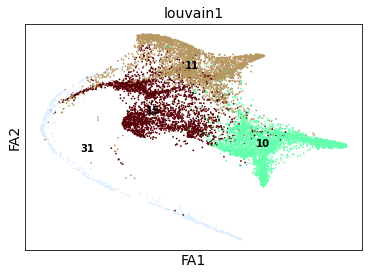

In [42]:
sc.pl.draw_graph(adata_dermamyotome,color='louvain1',legend_loc='on data')

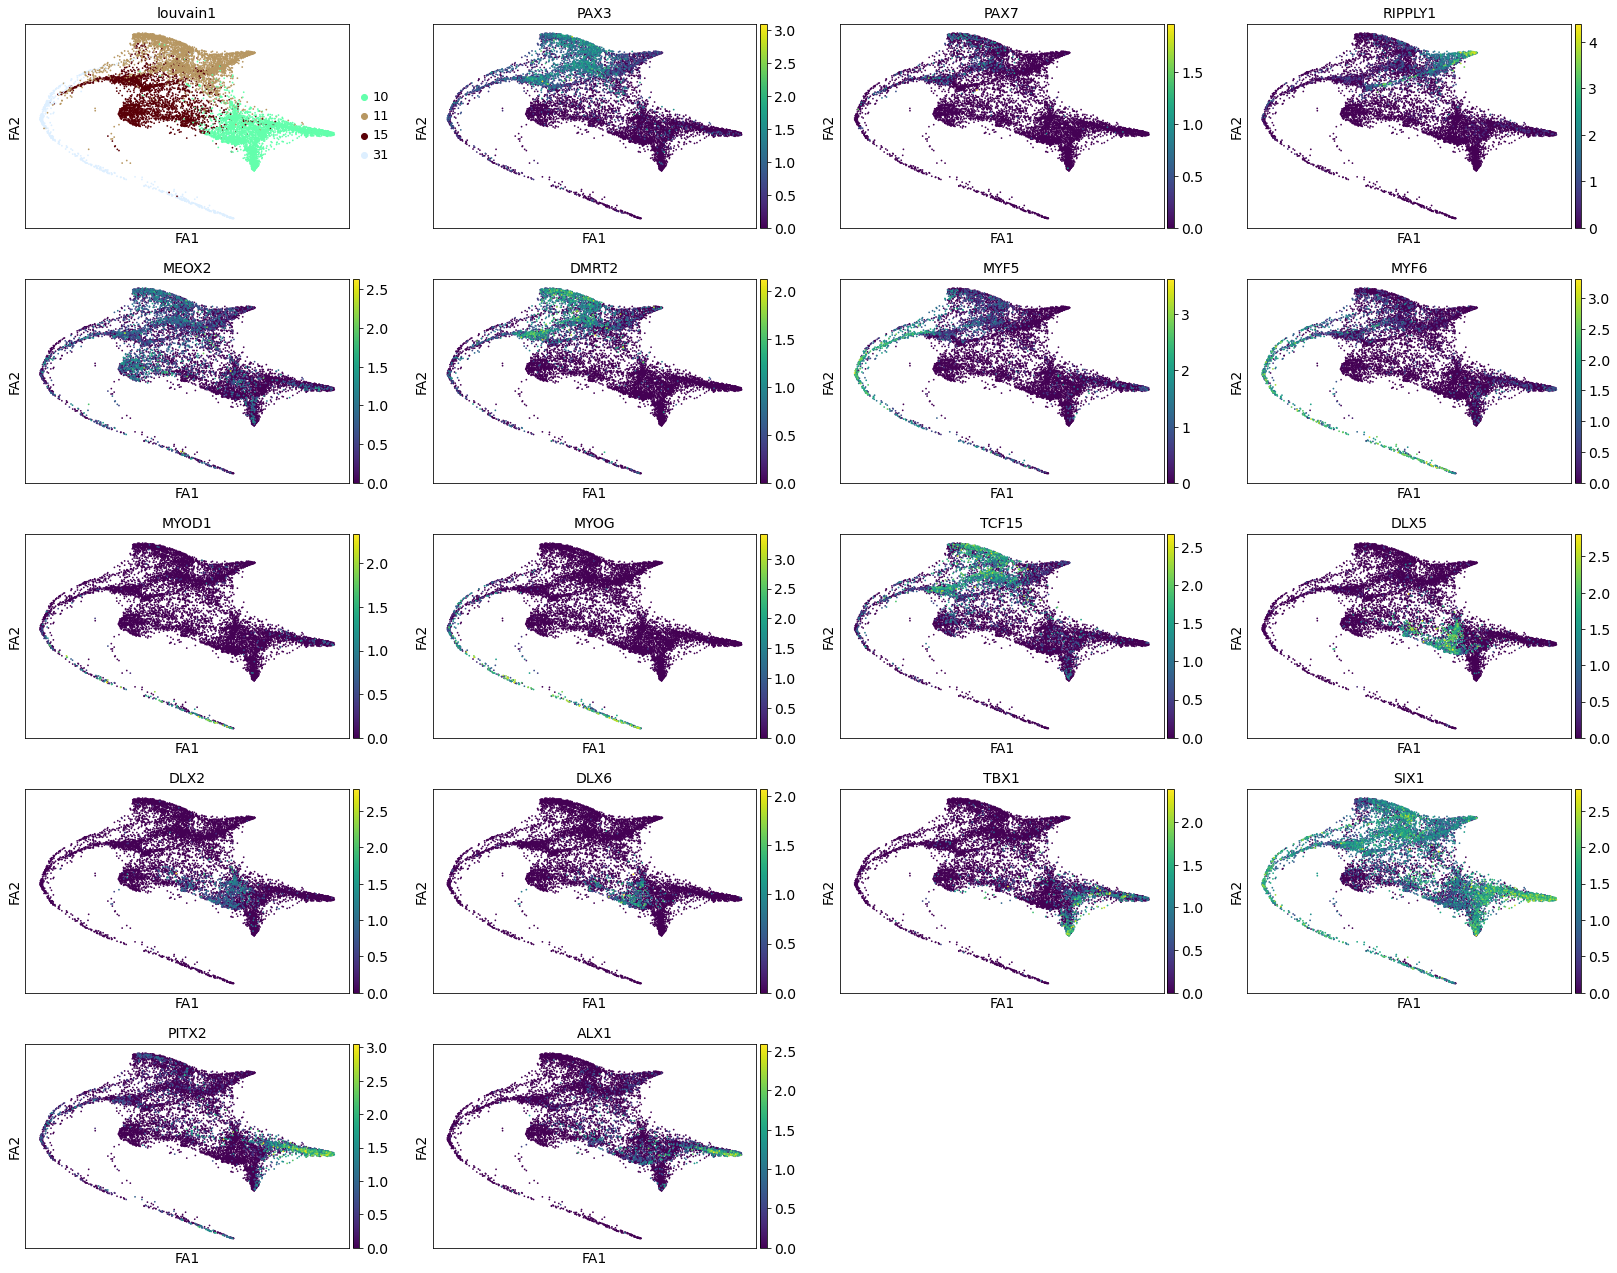

In [43]:
sc.pl.draw_graph(adata_dermamyotome, color=['louvain1','PAX3','PAX7','RIPPLY1','MEOX2','DMRT2','MYF5','MYF6','MYOD1','MYOG','TCF15','DLX5','DLX2','DLX6','TBX1',
                                                   'SIX1','PITX2','ALX1'])

In [44]:
new_cluster_names = ['Pharygeal mesoderm','Myotome','Proliferating dermomyotome','Myocyte']
adata_dermamyotome.obs['louvain1_name']=adata_dermamyotome.obs['louvain1']
adata_dermamyotome.rename_categories('louvain1_name', new_cluster_names)

<AxesSubplot:xlabel='FA1', ylabel='FA2'>

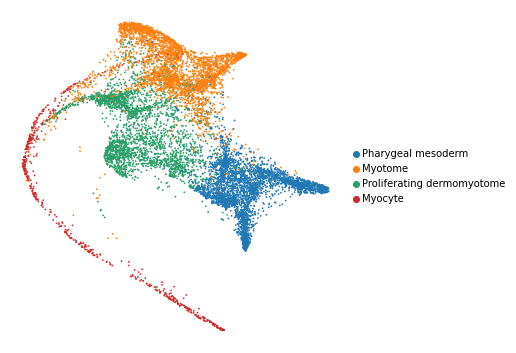

In [45]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.draw_graph(adata_dermamyotome, color='louvain1_name',frameon=False,title='', legend_fontsize=10,ax=ax,show=False)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2f_myocyte_lineage.pdf"), dpi=300, format='pdf', bbox_inches='tight')

<AxesSubplot:xlabel='FA1', ylabel='FA2'>

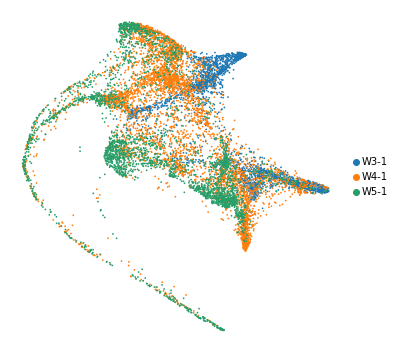

In [46]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.draw_graph(adata_dermamyotome, color='week_stage',frameon=False,title='', legend_fontsize=10,ax=ax,show=False)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2f_myocyte_lineage_week.pdf"), dpi=300, format='pdf', bbox_inches='tight')

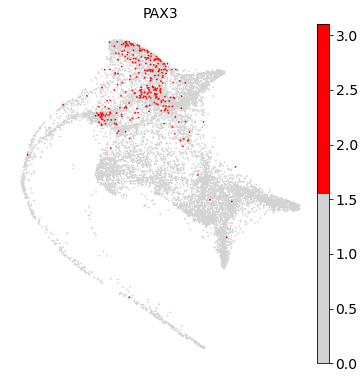

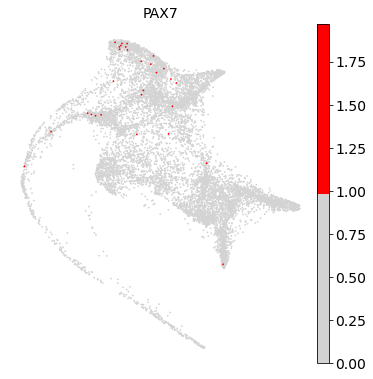

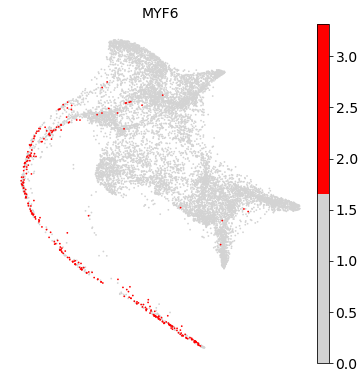

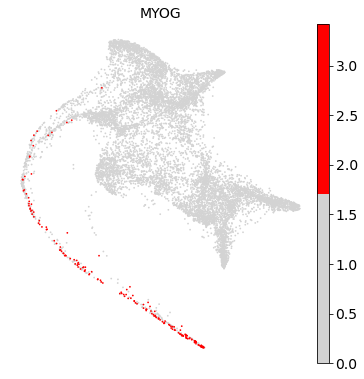

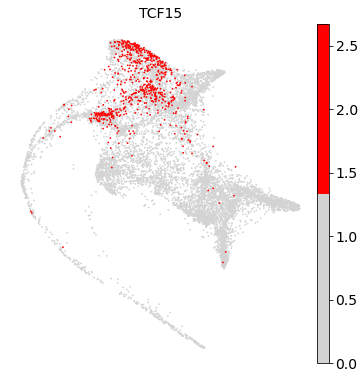

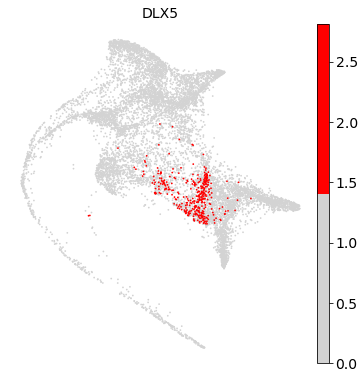

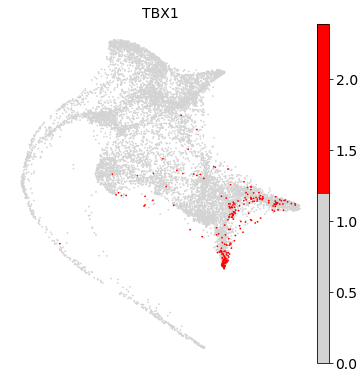

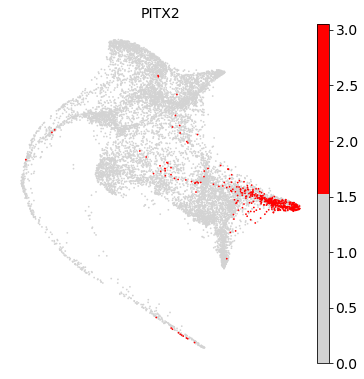

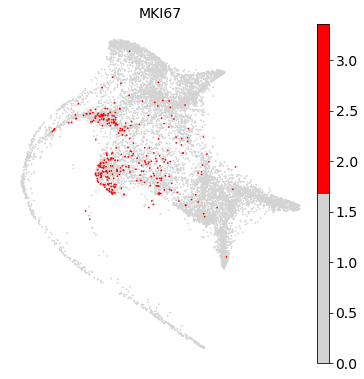

In [47]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
sclertome_genes=['PAX3','PAX7','MYF6','MYOG','TCF15','DLX5','TBX1',
                                                   'PITX2','MKI67']
cmap = colors.ListedColormap(['lightgray', 'red'])
for gn in sclertome_genes:
    fig, ax = plt.subplots(figsize=(6,6))
    sc.pl.draw_graph(adata_dermamyotome, color=gn,frameon=False,title=gn, legend_fontsize=10,ax=ax,show=False,color_map=cmap)
#     plt.savefig(os.path.join(paper_figure_dir,"Fig2f_myo_lineage_{}.pdf".format(gn)), dpi=300, format='pdf', bbox_inches='tight')

In [48]:
adata_dermamyotome.obs['louvain1_name'].cat.reorder_categories(['Proliferating dermomyotome', 'Pharygeal mesoderm', 'Myotome','Myocyte'],inplace=True)

In [49]:
adata_dermamyotome_v1=sc.AnnData(X=adata_dermamyotome.X,
                           obs=adata_dermamyotome.obs,
                           var=adata_dermamyotome.var)

/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:2233: RuntimeWarning: invalid value encountered in log1p
  matrix = np.log1p(matrix)


GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[13.8, 0, 0.2])

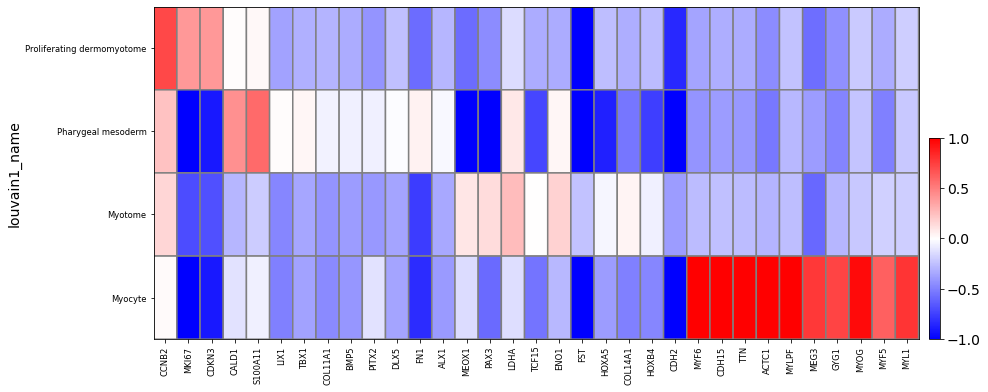

In [50]:
markers_pharyngeal = [ 'CALD1',  'S100A11',  'LIX1', 'TBX1', 'COL11A1', 'BMP5', 'PITX2', 'DLX5', 'FN1', 'ALX1']
markers_Myotome = [ 'MEOX1', 'PAX3',  'LDHA',  'TCF15',  'ENO1', 'FST', 'HOXA5',  'COL14A1',  'HOXB4',  'CDH2']
markers_Prolif_dermomyotome = [ 'CCNB2', 'MKI67', 'CDKN3']
markers_Myocyte = [ 'MYF6',  'CDH15',  'TTN', 'ACTC1', 'MYLPF', 'MEG3', 'GYG1', 'MYOG',  'MYF5',  'MYL1']
markers = markers_Prolif_dermomyotome+markers_pharyngeal+markers_Myotome+markers_Myocyte
sc.pl.matrixplot(adata_dermamyotome_v1,markers ,log=True,figsize=(14,6), groupby='louvain1_name',dendrogram=False,show=False,cmap='bwr',linewidth=1.5,vmax=1,vmin=-1,use_raw=False)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2h_myo_rank_genes.pdf_v3.pdf"), dpi=300, format='pdf', bbox_inches='tight')

# 3. Lateral plate mesoderm lineage

In [51]:
adata_test = adata.copy()
adata_test.X = adata.raw.X

In [52]:
lateral_plate_mesod_clusters=['8','1','24','29']

In [54]:
adata_lateral_plate_mesod = adata_test[adata_test.obs['louvain1'].isin(lateral_plate_mesod_clusters)]

In [55]:
# Perform basic filtering
sc.pp.filter_cells(adata_lateral_plate_mesod, min_genes=250)

# Before doing any further processing, store a raw version of the data
adata_lateral_plate_mesod.raw = adata_lateral_plate_mesod

# First, save current n_counts as n_counts_pre_norm (n_counts will be replaced)
adata_lateral_plate_mesod.obs['n_counts_pre_norm'] = adata_lateral_plate_mesod.obs['n_counts']

# Perform total counts normalization
sc.pp.normalize_total(adata_lateral_plate_mesod)

# Logarithmize the data
sc.pp.log1p(adata_lateral_plate_mesod)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata_lateral_plate_mesod, n_top_genes=500)

# Scale the data
sc.pp.scale(adata_lateral_plate_mesod)

Trying to set attribute `.obs` of view, making a copy.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [56]:
sc.tl.pca(adata_lateral_plate_mesod, n_comps=20, svd_solver='arpack')

computing PCA with n_comps = 20
computing PCA on highly variable genes
    finished (0:00:00.50)


In [57]:
pca_mesod = adata_lateral_plate_mesod.obsm['X_pca']
wg = adata_lateral_plate_mesod.obs['week_stage']

In [58]:
%%R -i pca_mesod -i wg
rownames(pca_mesod) = names(wg)
# rownames(pca_neuron)

In [59]:
%%R
pc_list = lapply(unique(wg), function(tp){
sub_pc = pca_mesod[wg == tp, , drop = FALSE]
return(sub_pc)
})
names(pc_list) = unique(wg)

In [60]:
%%R -o correct
# print(str(pc_list))
correct = do.call(fastMNN, c(pc_list, "pc.input" = TRUE, BPPARAM = SerialParam()))$corrected

In [61]:
adata_lateral_plate_mesod.obsm['X_pca'] = correct

In [62]:
# sc.pp.neighbors(adata_lateral_plate_mesod, n_neighbors=20, n_pcs=20, use_rep='X_pca') 
sc.pp.neighbors(adata_lateral_plate_mesod, n_neighbors=20, n_pcs=20, use_rep='X_pca') 

computing neighbors


/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished (0:00:08.93) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [63]:
sc.tl.draw_graph(adata_lateral_plate_mesod, layout='fa', iterations=400, random_state=0) # random_state=0 by default
sc.tl.diffmap(adata_lateral_plate_mesod)
sc.tl.umap(adata_lateral_plate_mesod)
sc.tl.louvain(adata_lateral_plate_mesod)

drawing single-cell graph using layout "fa"
    finished (0:01:08.60) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9973762  0.9915967  0.9845046  0.98285735 0.9808043
     0.9786145  0.9775294  0.9714055  0.9673667  0.9640136  0.96103907
     0.95791703 0.9543994  0.95121604]
    finished (0:00:00.45) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing UMAP
    finished (0:00:12.85) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.09) --> found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


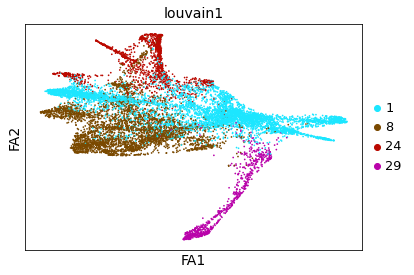

In [64]:
sc.pl.draw_graph(adata_lateral_plate_mesod,color='louvain1',legend_loc='right margin')

In [125]:
new_cluster_names = ['Somatic mesoderm','Proliferating lateral plate mesoderm','Splanchnic mesoderm','Cardiomyocyte']
adata_lateral_plate_mesod.obs['louvain1_name']=adata_lateral_plate_mesod.obs['louvain1']
adata_lateral_plate_mesod.rename_categories('louvain1_name', new_cluster_names)

<AxesSubplot:xlabel='FA1', ylabel='FA2'>

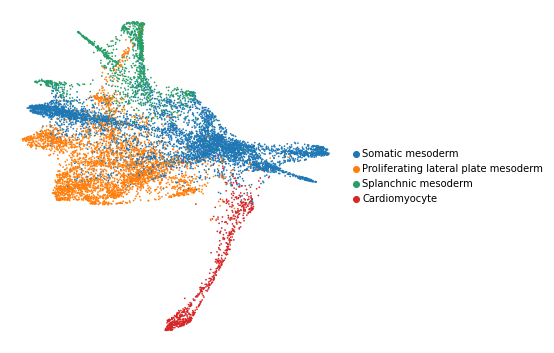

In [126]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.draw_graph(adata_lateral_plate_mesod,color='louvain1_name',frameon=False,title='', legend_fontsize=10,ax=ax,show=False)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2h_cardio_lineage.pdf"), dpi=300, format='pdf', bbox_inches='tight')

<AxesSubplot:xlabel='FA1', ylabel='FA2'>

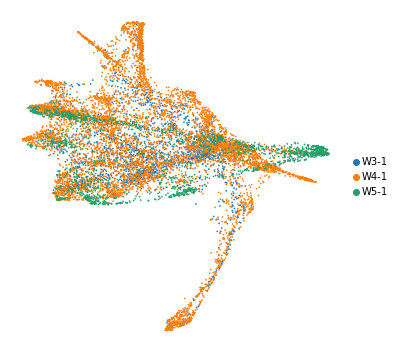

In [127]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.draw_graph(adata_lateral_plate_mesod,color='week_stage',frameon=False,title='', legend_fontsize=10,ax=ax,show=False)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2h_cardio_lineage_week.pdf"), dpi=300, format='pdf', bbox_inches='tight')

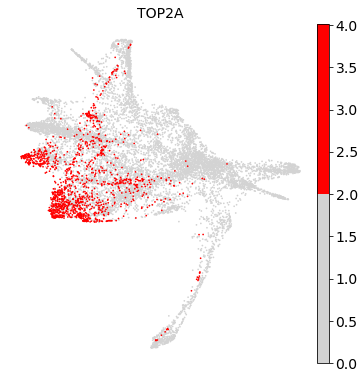

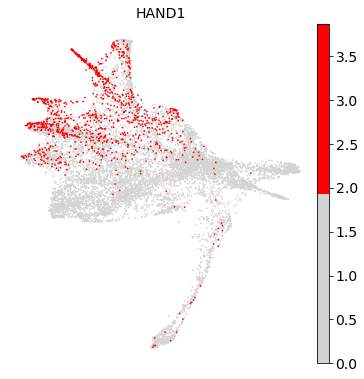

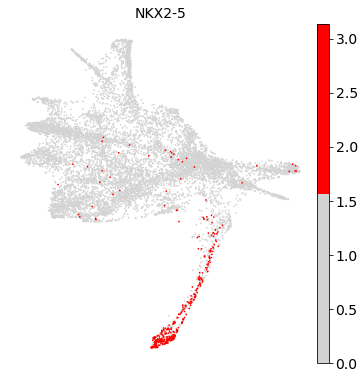

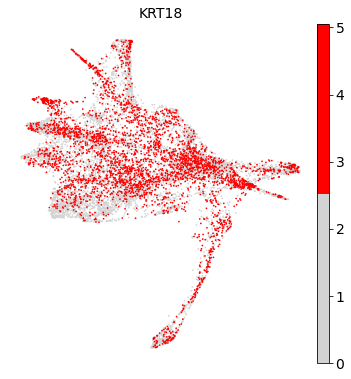

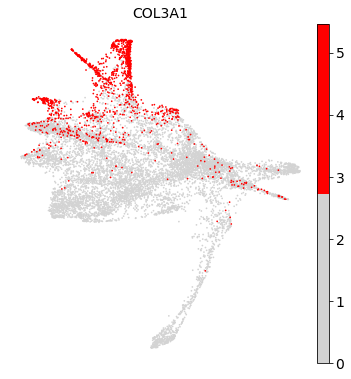

In [128]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
cardio_genes=['TOP2A','HAND1','NKX2-5','KRT18','COL3A1']
cmap = colors.ListedColormap(['lightgray', 'red'])
for gn in cardio_genes:
    fig, ax = plt.subplots(figsize=(6,6))
    sc.pl.draw_graph(adata_lateral_plate_mesod, color=gn,frameon=False,title=gn, legend_fontsize=10,ax=ax,show=False,color_map=cmap)
    # dew.format_axes(eq_aspect=[0], rm_colorbar=True)
#     plt.savefig(os.path.join(paper_figure_dir,"Fig2h_cardio_lineage_{}.pdf".format(gn)), dpi=300, format='pdf', bbox_inches='tight')

In [129]:
adata_lateral_plate_mesod_v1=adata_lateral_plate_mesod.copy()

In [130]:
adata_lateral_plate_mesod_v1.obs=adata_lateral_plate_mesod_v1.obs[['week_stage', 'louvain1', 'louvain1_name']]

<AxesSubplot:xlabel='FA1', ylabel='FA2'>

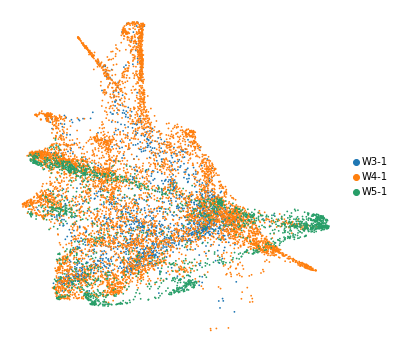

In [131]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.draw_graph(adata_lateral_plate_mesod_v1[adata_lateral_plate_mesod_v1.obs['louvain1'].ne('29'),:],color='week_stage',frameon=False,title='', legend_fontsize=10,ax=ax,show=False)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2h_cardio_lineage_week_v1.pdf"), dpi=300, format='pdf', bbox_inches='tight')

<AxesSubplot:xlabel='FA1', ylabel='FA2'>

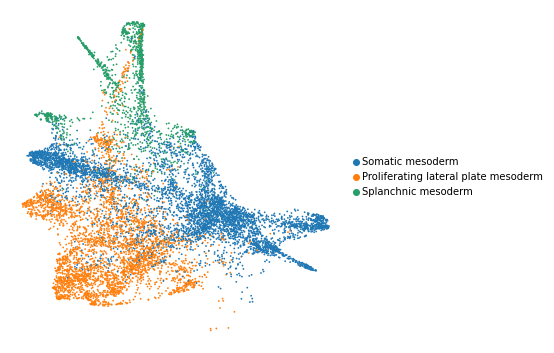

In [133]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.draw_graph(adata_lateral_plate_mesod_v1[adata_lateral_plate_mesod_v1.obs['louvain1_name'].isin(['Somatic mesoderm','Proliferating lateral plate mesoderm','Splanchnic mesoderm'])],color='louvain1_name',frameon=False,title='', legend_fontsize=10,ax=ax,show=False)

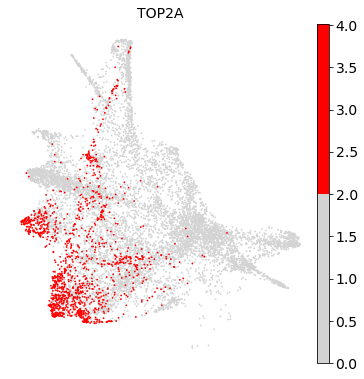

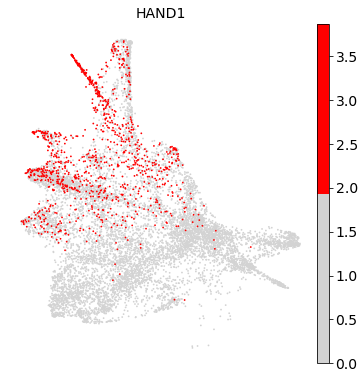

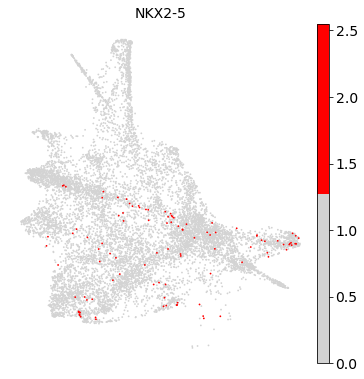

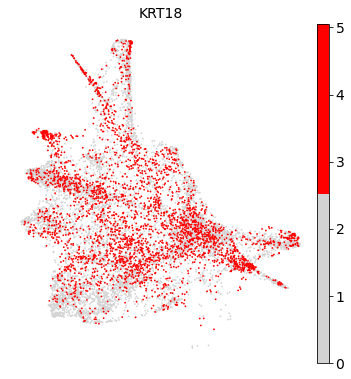

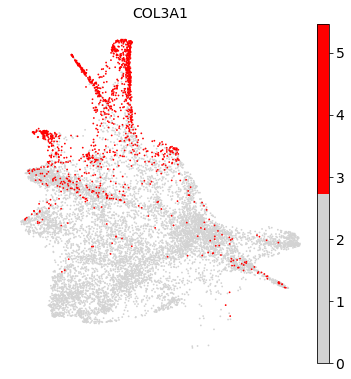

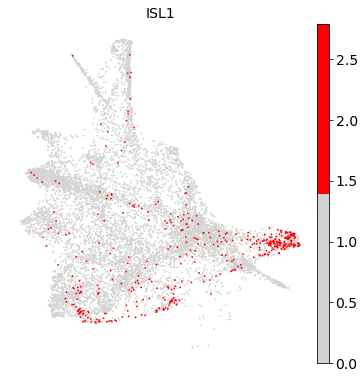

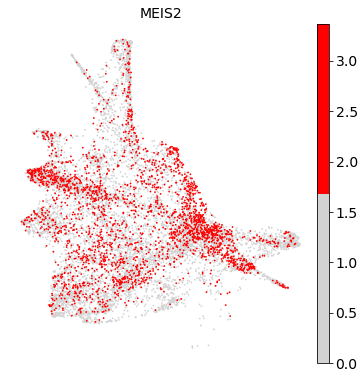

In [134]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
cardio_genes=['TOP2A','HAND1','NKX2-5','KRT18','COL3A1','ISL1','MEIS2']
cmap = colors.ListedColormap(['lightgray', 'red'])
for gn in cardio_genes:
    fig, ax = plt.subplots(figsize=(6,6))
    sc.pl.draw_graph(adata_lateral_plate_mesod_v1[adata_lateral_plate_mesod_v1.obs['louvain1'].ne('29'),:], color=gn,frameon=False,title=gn, legend_fontsize=10,ax=ax,show=False,color_map=cmap)
#     dew.format_axes(eq_aspect=[0], rm_colorbar=True)
#     plt.savefig(os.path.join(paper_figure_dir,"Fig2h_cardio_lineage_{}_v1.pdf".format(gn)), dpi=300, format='pdf', bbox_inches='tight')

In [136]:
adata_lateral_plate_mesod_v1.obs['louvain1_name'].cat.reorder_categories(['Proliferating lateral plate mesoderm', 'Somatic mesoderm', 'Splanchnic mesoderm', 'Cardiomyocyte'],inplace=True)

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[13.8, 0, 0.2])

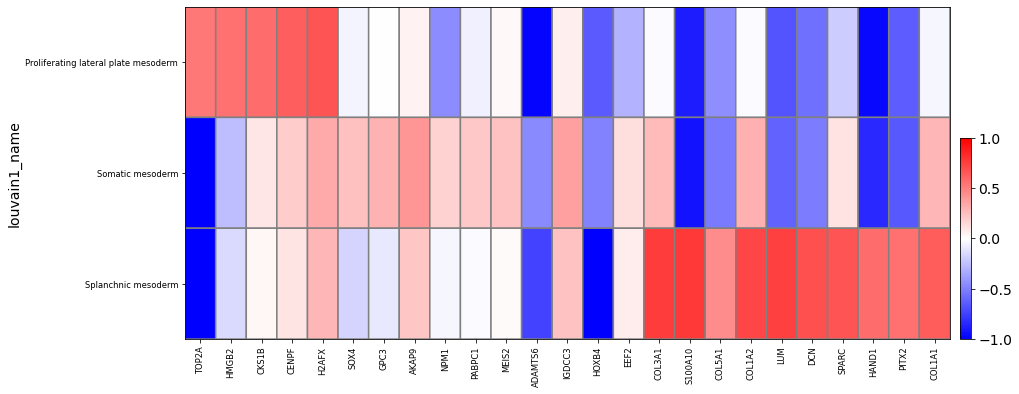

In [137]:
markers_somitic_mesod = ['SOX4','GPC3','AKAP9','NPM1','PABPC1','MEIS2','ADAMTS6','IGDCC3','HOXB4','EEF2']
markers_prolif_lateral_plate_mesod=['TOP2A', 'HMGB2','CKS1B', 'CENPF', 'H2AFX']
markers_splanchnic_mesod=['COL3A1', 'S100A10', 'COL5A1', 'COL1A2', 'LUM', 'DCN', 'SPARC', 'HAND1', 'PITX2', 'COL1A1']
markers_Cardiomyocyte=['ACTC1', 'NKX2-5', 'TNNT2', 'MYL4',  'TPM1', 'NEBL', 'ENO3', 'MYH6', 'NEXN',  'HSPB7']
markers=markers_prolif_lateral_plate_mesod+markers_somitic_mesod+markers_splanchnic_mesod
sc.pl.matrixplot(adata_lateral_plate_mesod_v1[adata_lateral_plate_mesod_v1.obs['louvain1'].ne('29'),:],markers ,log=True,figsize=(14,6), groupby='louvain1_name',dendrogram=False,show=False,cmap='bwr',linewidth=1.5,vmax=1,vmin=-1,use_raw=False)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2h_cardio_rank_genes_v4.pdf"), dpi=300, format='pdf', bbox_inches='tight')

# 5 Intermediate mesoderm lineage

In [138]:
adata_test = adata.copy()
adata_test.X = adata.raw.X

In [140]:
intermediate_mesoderm_clusters=['21']

In [141]:
adata_intermed = adata_test[adata_test.obs['louvain'].isin(intermediate_mesoderm_clusters)]

In [142]:
# Perform basic filtering
sc.pp.filter_cells(adata_intermed, min_genes=250)

# Before doing any further processing, store a raw version of the data
adata_intermed.raw = adata_intermed

# First, save current n_counts as n_counts_pre_norm (n_counts will be replaced)
adata_intermed.obs['n_counts_pre_norm'] = adata_intermed.obs['n_counts']

# Perform total counts normalization
sc.pp.normalize_total(adata_intermed)

# Logarithmize the data
sc.pp.log1p(adata_intermed)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata_intermed, n_top_genes=500)

# Scale the data
sc.pp.scale(adata_intermed)

Trying to set attribute `.obs` of view, making a copy.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [143]:
# Perform PCA and construct neighbor graph
sc.tl.pca(adata_intermed, n_comps=20, svd_solver='arpack')

computing PCA with n_comps = 20
computing PCA on highly variable genes
    finished (0:00:00.14)


In [144]:
pca_mesod = adata_intermed.obsm['X_pca']
wg = adata_intermed.obs['week_stage']

In [145]:
%%R -i pca_mesod -i wg
rownames(pca_mesod) = names(wg)
# rownames(pca_neuron)

In [146]:
%%R
pc_list = lapply(unique(wg), function(tp){
sub_pc = pca_mesod[wg == tp, , drop = FALSE]
return(sub_pc)
})
names(pc_list) = unique(wg)

In [147]:
%%R -o correct
# print(str(pc_list))
correct = do.call(fastMNN, c(pc_list, "pc.input" = TRUE, BPPARAM = SerialParam()))$corrected

In [148]:
adata_intermed.obsm['X_pca'] = correct

In [149]:
sc.pp.neighbors(adata_intermed, n_neighbors=20, n_pcs=20, use_rep='X_pca') 
sc.tl.draw_graph(adata_intermed, layout='fa', iterations=400, random_state=0) # random_state=0 by default
sc.tl.diffmap(adata_intermed)
sc.tl.umap(adata_intermed)
sc.tl.louvain(adata_intermed,resolution=0.2)

computing neighbors
    finished (0:00:01.26) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fa"
    finished (0:00:05.86) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.984344   0.97374624 0.9647457  0.9497296  0.9389721
     0.9355649  0.9303245  0.90478057 0.8927915  0.8899375  0.8811339
     0.8618299  0.84993756 0.84565556]
    finished (0:00:00.08) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing UMAP
    finished (0:00:05.99) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.12) --> found 3 clusters and added
    'louvain', the cluster label

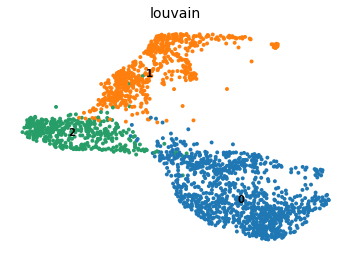

In [150]:
sc.pl.draw_graph(adata_intermed,color='louvain',legend_loc='on data',frameon=False)

In [151]:
new_cluster_names = ['Gentourinary system 2','Intermediate Mesoderm Cell','Gentourinary system 1']
adata_intermed.obs['louvain_name']=adata_intermed.obs['louvain']
adata_intermed.rename_categories('louvain_name', new_cluster_names)

<AxesSubplot:xlabel='FA1', ylabel='FA2'>

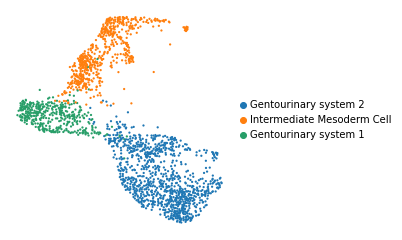

In [152]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
fig, ax = plt.subplots(figsize=(4,4))
sc.pl.draw_graph(adata_intermed,components='1,2', color='louvain_name',frameon=False,title='', legend_fontsize=10,ax=ax,show=False,size=20)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2g_intermed_lineage_v2.pdf"), dpi=300, format='pdf', bbox_inches='tight')

<AxesSubplot:xlabel='FA1', ylabel='FA2'>

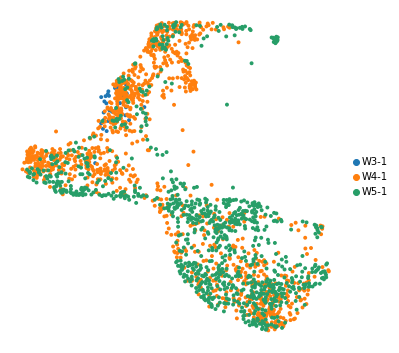

In [153]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.draw_graph(adata_intermed,components='1,2', color='week_stage',frameon=False,title='', legend_fontsize=10,ax=ax,show=False)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2g_intermed_lineage_week_v1.pdf"), dpi=300, format='pdf', bbox_inches='tight')

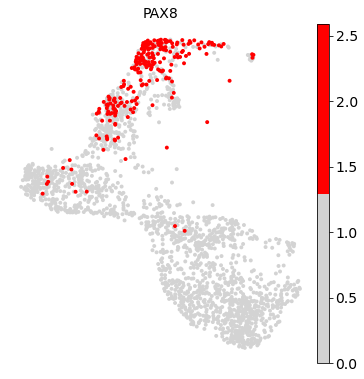

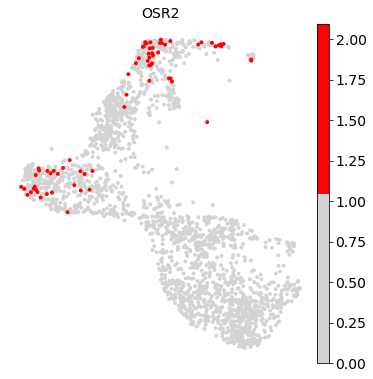

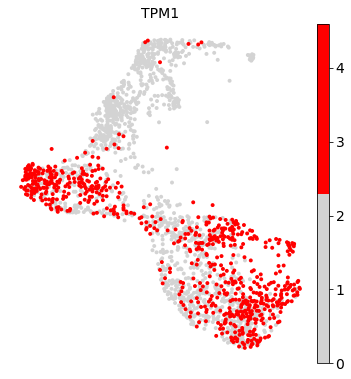

In [154]:
import os
paper_figure_dir="/datb/home/wanglab13/PythonScripts/Paper_figures/paper_figures"
sclertome_genes=['PAX8','OSR2','TPM1']
cmap = colors.ListedColormap(['lightgray', 'red'])
for gn in sclertome_genes:
    fig, ax = plt.subplots(figsize=(6,6))
    sc.pl.draw_graph(adata_intermed,components='1,2', color=gn,frameon=False,title=gn, legend_fontsize=10,ax=ax,show=False,color_map=cmap)
#     plt.savefig(os.path.join(paper_figure_dir,"Fig2g_intermed_lineage_{}_v1.pdf".format(gn)), dpi=300, format='pdf', bbox_inches='tight')

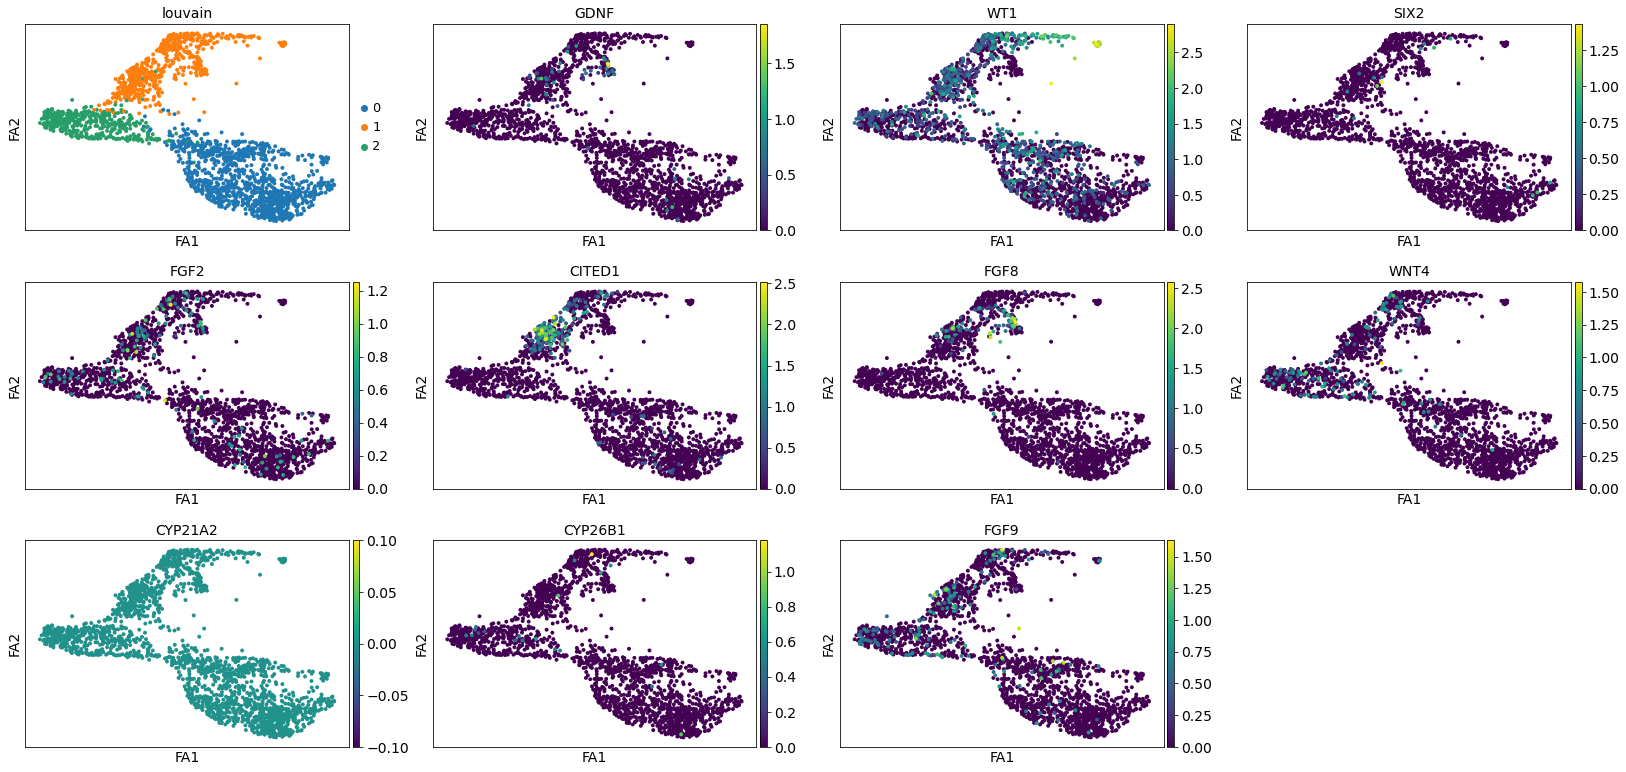

In [155]:
sc.pl.draw_graph(adata_intermed, components='1,2', color=['louvain','GDNF','WT1','SIX2','FGF2','CITED1','FGF8','WNT4','CYP21A2','CYP26B1','FGF9'])

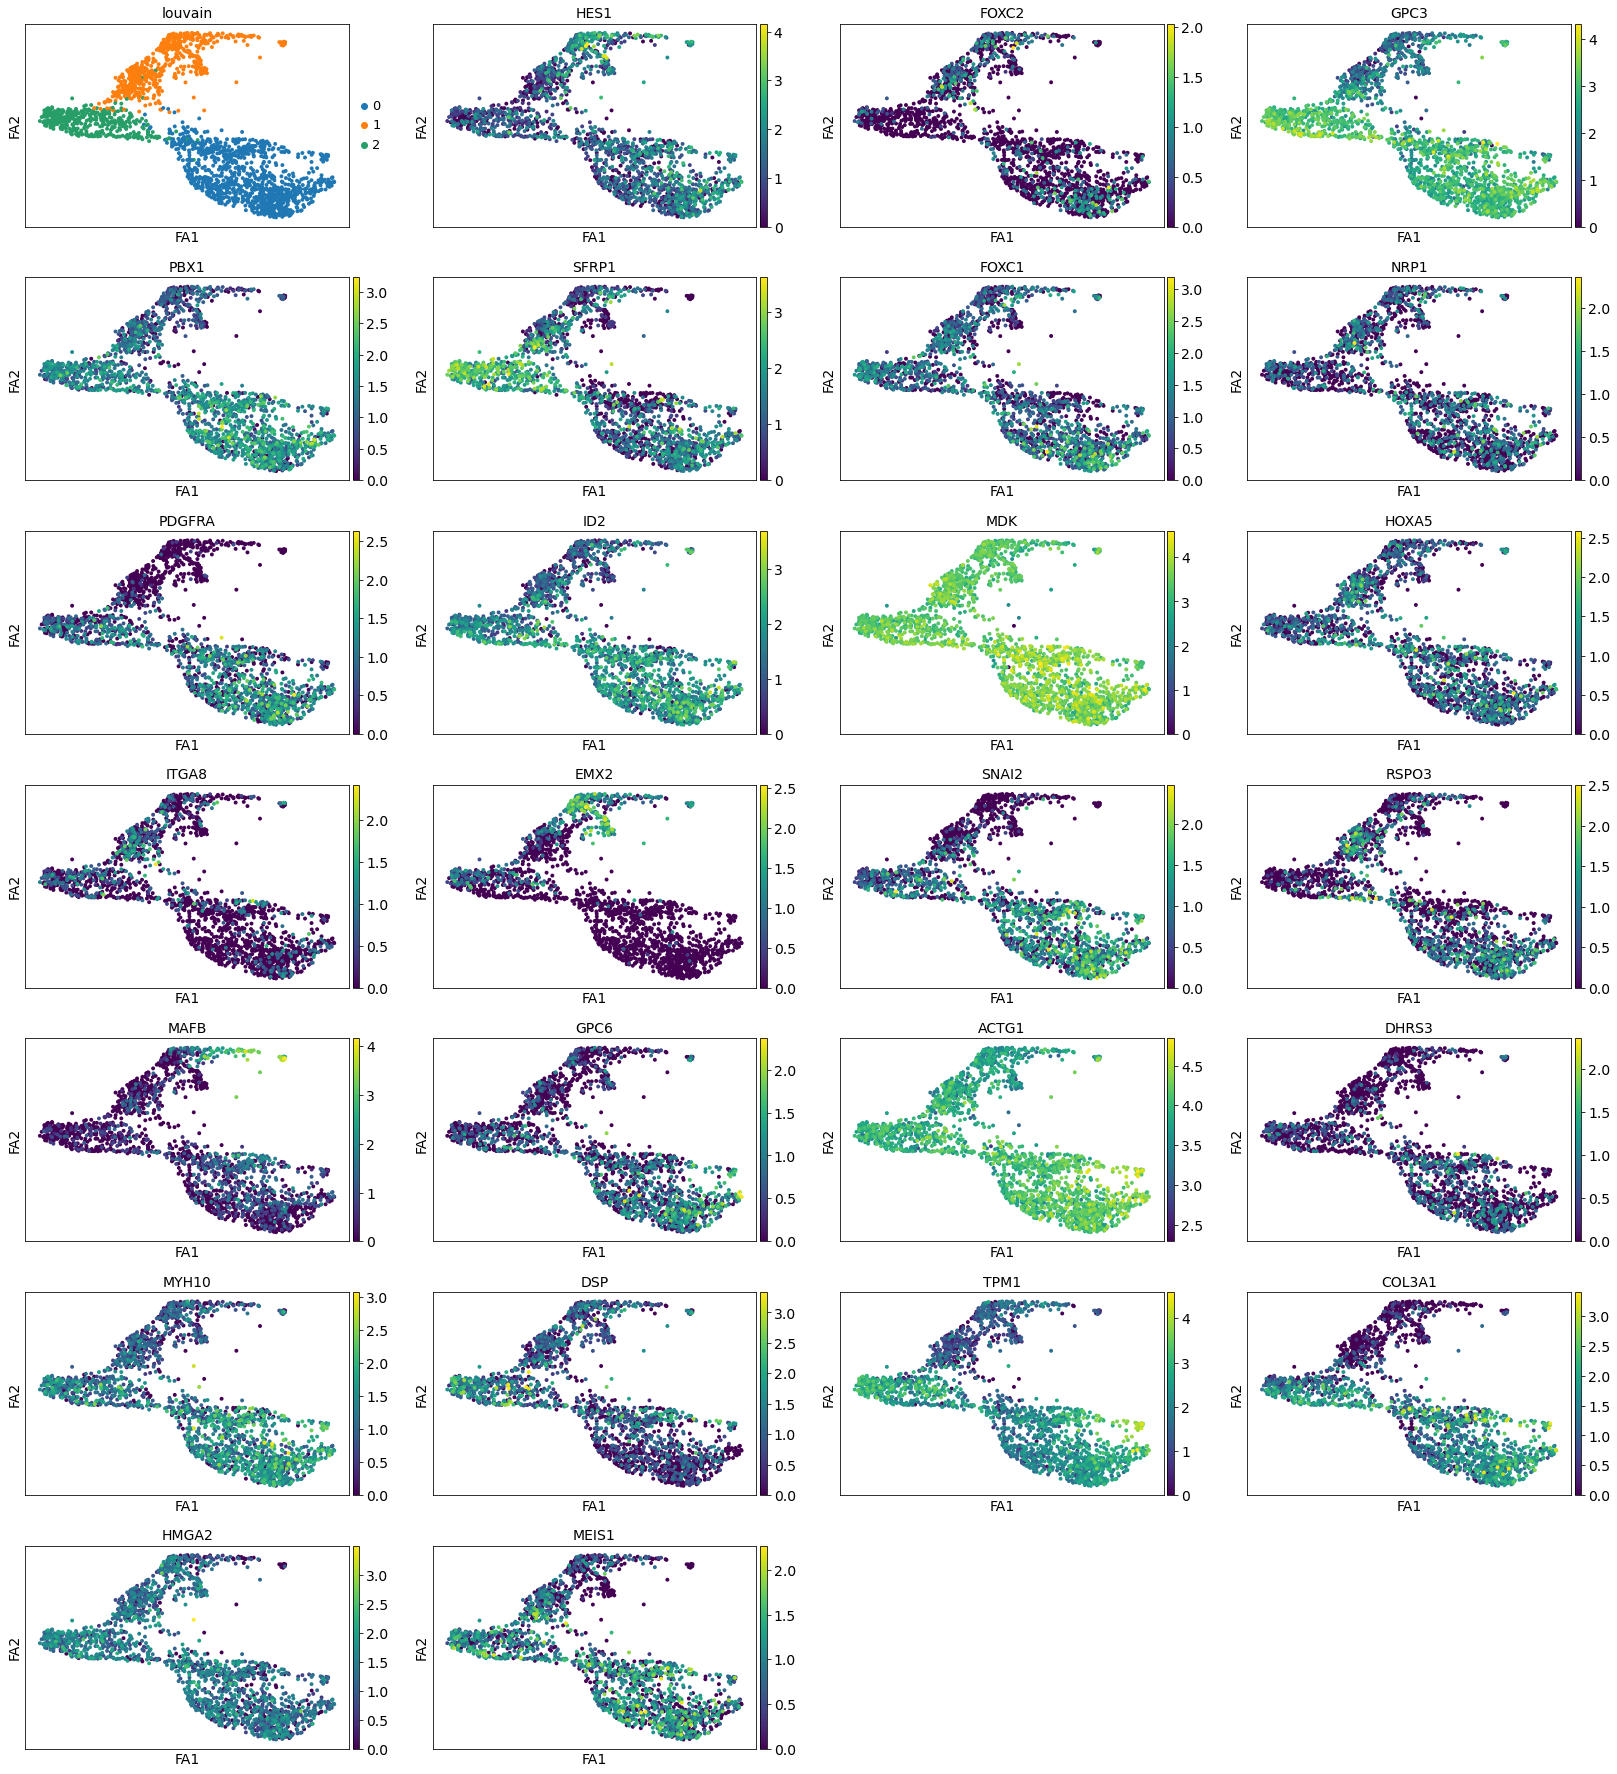

In [156]:
sc.pl.draw_graph(adata_intermed, components='1,2', color=['louvain','HES1','FOXC2','GPC3','PBX1','SFRP1','FOXC1','NRP1','PDGFRA','ID2','MDK','HOXA5','ITGA8','EMX2','SNAI2','RSPO3','MAFB','GPC6',
                                                       'ACTG1','DHRS3','MYH10','DSP','TPM1','COL3A1','HMGA2','MEIS1'])

In [157]:
adata_intermed.obs['louvain_name'].cat.reorder_categories(['Intermediate Mesoderm Cell','Gentourinary system 1','Gentourinary system 2'],inplace=True)

/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:2233: RuntimeWarning: invalid value encountered in log1p
  matrix = np.log1p(matrix)


GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[13.8, 0, 0.2])

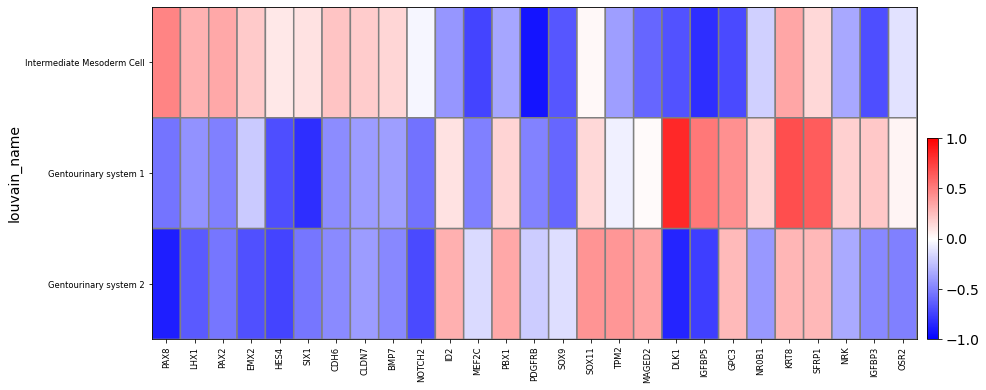

In [158]:
markers_intermediate=['PAX8', 'LHX1',  'PAX2', 'EMX2',  'HES4',  'SIX1', 'CDH6',  'CLDN7',  'BMP7', 'NOTCH2' ]
markers_Gentourinary1 = ['ID2','MEF2C','PBX1','PDGFRB','SOX9','SOX11','TPM2','MAGED2']
markers_Gentourinary2=['DLK1','IGFBP5','GPC3','NR0B1','KRT8','SFRP1','NRK','IGFBP3','OSR2']
markers = markers_intermediate+markers_Gentourinary1+markers_Gentourinary2
sc.pl.matrixplot(adata_intermed,markers ,log=True,figsize=(14,6), groupby='louvain_name',dendrogram=False,show=False,cmap='bwr',linewidth=1.5,vmax=1,vmin=-1,use_raw=False)
# plt.savefig(os.path.join(paper_figure_dir,"Fig2h_intermed_rank_genes_v3.pdf"), dpi=300, format='pdf', bbox_inches='tight')